# Modeling, Solving, and Extending Operations Analytics Optimization Problems

**Solver:** SCIP (from Google OR-Tools)

This notebook addresses:
- (a) Implementation of the original LP formulation from Akpan (2016)
- (b) Implementation of the extended model
- (c) Implementation of the scenarios proposed for Model Testing and Scenario Analysis


In [3]:
# Installing OR Tools

!pip install ortools

In [17]:
# Import necessary packages

from ortools.linear_solver import pywraplp
import pandas as pd
import matplotlib.pyplot as plt


# Function to plot
def plot_loaf_mix_with_labels(scenario, big, giant, small):
    plt.figure(figsize=(8, 6))
    loaves = ['Big Loaves', 'Giant Loaves', 'Small Loaves']
    values = [big, giant, small]

    bars = plt.bar(loaves, values, color='steelblue')
    plt.title(f'Loaf Mix – {scenario}', fontsize=12)
    plt.ylabel('Quantity Produced')


    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5,
                 f'{int(height)}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.grid(False)
    plt.show()

## (a) Implementation of the original LP formulation from Akpan (2016)

      Loaf Type  Quantity Produced  Unit Profit (₦)
0    Big Loaves               38.0               30
1  Giant Loaves                0.0               40
2  Small Loaves              962.0               20

Total Maximum Profit: ₦20,380.00


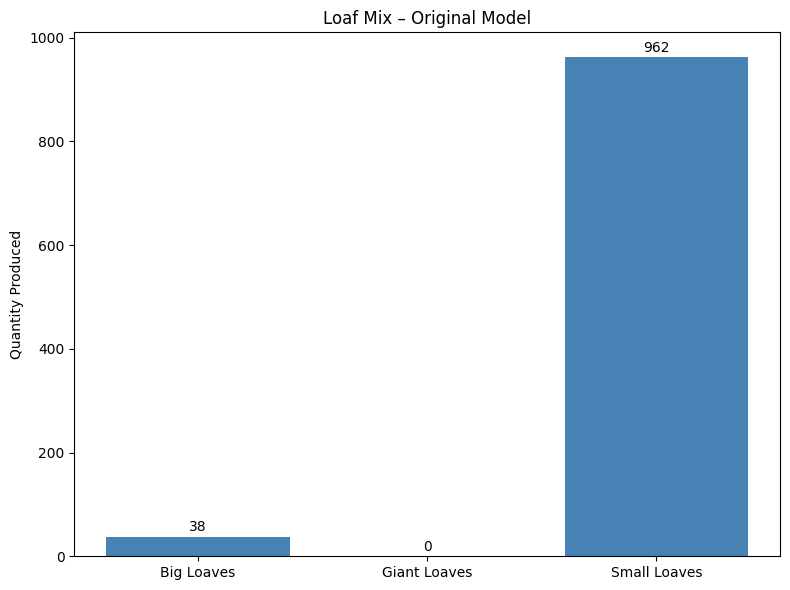

In [18]:
# Create solver

solver = pywraplp.Solver.CreateSolver('SCIP')

# Defining decision variables

x1 = solver.IntVar(0, solver.infinity(), 'x1')  # Big loaves
x2 = solver.IntVar(0, solver.infinity(), 'x2')  # Giant loaves
x3 = solver.IntVar(0, solver.infinity(), 'x3')  # Small loaves

# Defining available raw materials (grams/mililiters)

flour = 200000
sugar = 160
yeast = 20000
salt = 8500
gluten = 15
soybean_oil = 10000

# Adding constraints based on material usage

solver.Add(200 * x1 + 240 * x2 + 140 * x3 <= flour)                # Flour
solver.Add(0.14 * x1 + 0.20 * x2 + 0.16 * x3 <= sugar)             # Sugar
solver.Add(20 * x1 + 20 * x2 + 20 * x3 <= yeast)                   # Yeast
solver.Add(0.0011 * x1 + 0.00105 * x2 + 0.00017 * x3 <= salt)      # Salt
solver.Add(0.000167 * x1 + 0.002 * x2 + 0.00012 * x3 <= gluten)    # Gluten
solver.Add(15 * x1 + 21 * x2 + 9.8 * x3 <= soybean_oil)            # Soybean oil

# Defining the objective function (maximize profit)

profit = solver.Objective()
profit.SetCoefficient(x1, 30)   # Profit per Big loaf
profit.SetCoefficient(x2, 40)  # Profit per Giant loaf
profit.SetCoefficient(x3, 20)   # Profit per Small loaf
profit.SetMaximization()

#Solve the model

status = solver.Solve()

# Output results
if status == pywraplp.Solver.OPTIMAL:
    output_data = {
        'Loaf Type': ['Big Loaves', 'Giant Loaves', 'Small Loaves'],
        'Quantity Produced': [x1.solution_value(), x2.solution_value(), x3.solution_value()],
        'Unit Profit (₦)': [30, 40, 20]
    }
    df_results = pd.DataFrame(output_data)
    print(df_results)
    print(f"\nTotal Maximum Profit: ₦{solver.Objective().Value():,.2f}")
else:
    print("No optimal solution found.")

plot_loaf_mix_with_labels("Original Model", x1.solution_value(), x2.solution_value(), x3.solution_value())



## (b) Implementation of the extended model

      Loaf Type  Quantity Produced  Unit Profit (₦)
0    Big Loaves                 20               30
1  Giant Loaves                  0               40
2  Small Loaves                920               20

Shifts Used: 2 (Shift 1: 1, Shift 2: 1)
Total Profit (after shift and labor costs): ₦16,280.00


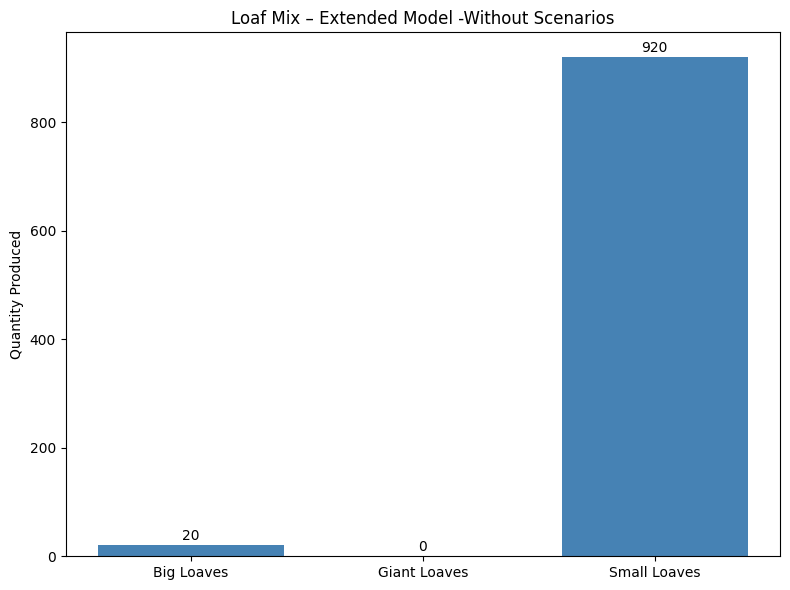

In [19]:
# Create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Define batch variables (integer)
z1 = solver.IntVar(0, solver.infinity(), 'z1')  # Batches of big loaves (5 units)
z2 = solver.IntVar(0, solver.infinity(), 'z2')  # Batches of giant loaves (2 units)
z3 = solver.IntVar(0, solver.infinity(), 'z3')  # Batches of small loaves (10 units)

# Define product quantities based on lot sizing
x1 = solver.IntVar(0, solver.infinity(), 'x1')  # Big loaves
x2 = solver.IntVar(0, solver.infinity(), 'x2')  # Giant loaves
x3 = solver.IntVar(0, solver.infinity(), 'x3')  # Small loaves

# Binary decision variables for shift activation
y1 = solver.BoolVar('y1')  # Shift 1
y2 = solver.BoolVar('y2')  # Shift 2

# Lot sizing constraints
solver.Add(x1 == 5 * z1)
solver.Add(x2 == 2 * z2)
solver.Add(x3 == 10 * z3)

# Raw material constraints
solver.Add(0.20 * x1 + 0.24 * x2 + 0.14 * x3 <= 2000)         # Flour
solver.Add(0.14 * x1 + 0.20 * x2 + 0.16 * x3 <= 1600)         # Sugar
solver.Add(0.02 * x1 + 0.02 * x2 + 0.02 * x3 <= 200)          # Yeast
solver.Add(0.0011 * x1 + 0.00105 * x2 + 0.00017 * x3 <= 8.5)  # Salt
solver.Add(0.000167 * x1 + 0.002 * x2 + 0.00012 * x3 <= 15)   # Gluten
solver.Add(0.0157 * x1 + 0.021 * x2 + 0.0098 * x3 <= 10)      # Soybean oil

# Labor time constraint
solver.Add(6 * x1 + 9 * x2 + 3 * x3 <= 1440 * y1 + 1440 * y2)

# Minimum production demand
solver.Add(x1 >= 20)
solver.Add(x3 >= 600)

# Objective function: profit - shift cost - labor cost
objective = solver.Objective()
objective.SetCoefficient(x1, 30 - (6 * 0.25))
objective.SetCoefficient(x2, 40 - (9 * 0.25))
objective.SetCoefficient(x3, 20 - (3 * 0.25))
objective.SetCoefficient(y1, -1000)
objective.SetCoefficient(y2, -1000)
objective.SetMaximization()

# Solve the model
status = solver.Solve()

# Output results
if status == pywraplp.Solver.OPTIMAL:
    output_data = {
        'Loaf Type': ['Big Loaves', 'Giant Loaves', 'Small Loaves'],
        'Quantity Produced': [int(x1.solution_value()), int(x2.solution_value()), int(x3.solution_value())],
        'Unit Profit (₦)': [30, 40, 20]
    }
    df_results = pd.DataFrame(output_data)
    print(df_results)

    print(f"\nShifts Used: {int(y1.solution_value()) + int(y2.solution_value())} "
          f"(Shift 1: {int(y1.solution_value())}, Shift 2: {int(y2.solution_value())})")

    print(f"Total Profit (after shift and labor costs): ₦{solver.Objective().Value():,.2f}")
else:
    print("No optimal solution found.")

plot_loaf_mix_with_labels("Extended Model -Without Scenarios", x1.solution_value(), x2.solution_value(), x3.solution_value())

## (c) Implementation of the scenarios proposed for Model Testing and Scenario Analysis

In [10]:
scenarios = ['A', 'B', 'C', 'D', 'E']

from ortools.linear_solver import pywraplp
import pandas as pd

def solve_bakery_model(scenario):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    z1 = solver.IntVar(0, solver.infinity(), 'z1')
    z2 = solver.IntVar(0, solver.infinity(), 'z2')
    z3 = solver.IntVar(0, solver.infinity(), 'z3')
    x1 = solver.IntVar(0, solver.infinity(), 'x1')
    x2 = solver.IntVar(0, solver.infinity(), 'x2')
    x3 = solver.IntVar(0, solver.infinity(), 'x3')
    if scenario != 'D':
        solver.Add(x1 == 5 * z1)
        solver.Add(x2 == 2 * z2)
        solver.Add(x3 == 10 * z3)
    y1 = solver.IntVar(0, 1, 'y1')
    y2 = solver.IntVar(0, 1, 'y2')

    flour = 200000 if scenario not in ['A'] else 240000
    sugar = 160 if scenario not in ['C'] else 112
    yeast = 20000
    salt = 8500
    gluten = 15
    soybean_oil = 10000

    solver.Add(200 * x1 + 240 * x2 + 140 * x3 <= flour)
    solver.Add(0.14 * x1 + 0.20 * x2 + 0.16 * x3 <= sugar)
    solver.Add(20 * x1 + 20 * x2 + 20 * x3 <= yeast)
    solver.Add(0.0011 * x1 + 0.00105 * x2 + 0.00017 * x3 <= salt)
    solver.Add(0.000167 * x1 + 0.002 * x2 + 0.00012 * x3 <= gluten)
    solver.Add(15 * x1 + 21 * x2 + 9.8 * x3 <= soybean_oil)

    solver.Add(x1 >= 20)
    solver.Add(x3 >= 300)

    solver.Add(6 * x1 + 9 * x2 + 3 * x3 <= 1440 * y1 + 1440 * y2)
    if scenario == 'E':
        solver.Add(y1 == 1)
        solver.Add(y2 == 0)

    objective = solver.Objective()
    objective.SetCoefficient(x1, 30)
    objective.SetCoefficient(x2, 40)
    objective.SetCoefficient(x3, 20)
    objective.SetCoefficient(y1, -1000)
    objective.SetCoefficient(y2, -1000)

    labor_cost = 0.25 if scenario != 'B' else 0.50
    objective.SetCoefficient(x1, objective.GetCoefficient(x1) - 6 * labor_cost)
    objective.SetCoefficient(x2, objective.GetCoefficient(x2) - 9 * labor_cost)
    objective.SetCoefficient(x3, objective.GetCoefficient(x3) - 3 * labor_cost)

    objective.SetMaximization()

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        result = {
            'Scenario': scenario,
            'Big Loaves': x1.solution_value(),
            'Giant Loaves': x2.solution_value(),
            'Small Loaves': x3.solution_value(),
            'Shifts Used': y1.solution_value() + y2.solution_value(),
            'Total Profit (₦)': round(solver.Objective().Value(), 2)
        }
    else:
        result = {
            'Scenario': scenario,
            'Big Loaves': None,
            'Giant Loaves': None,
            'Small Loaves': None,
            'Shifts Used': None,
            'Total Profit (₦)': 'Infeasible'
        }
    return result

# Run and collect results
scenarios = ['A', 'B', 'C', 'D', 'E']
results = [solve_bakery_model(s) for s in scenarios]
df_results = pd.DataFrame(results)
print(df_results)



  Scenario  Big Loaves  Giant Loaves  Small Loaves  Shifts Used  \
0        A        20.0           0.0         920.0          2.0   
1        B        20.0           0.0         920.0          2.0   
2        C       235.0           0.0         490.0          2.0   
3        D        20.0           0.0         920.0          2.0   
4        E        20.0           0.0         440.0          1.0   

   Total Profit (₦)  
0           16280.0  
1           15560.0  
2           14130.0  
3           16280.0  
4            8040.0  


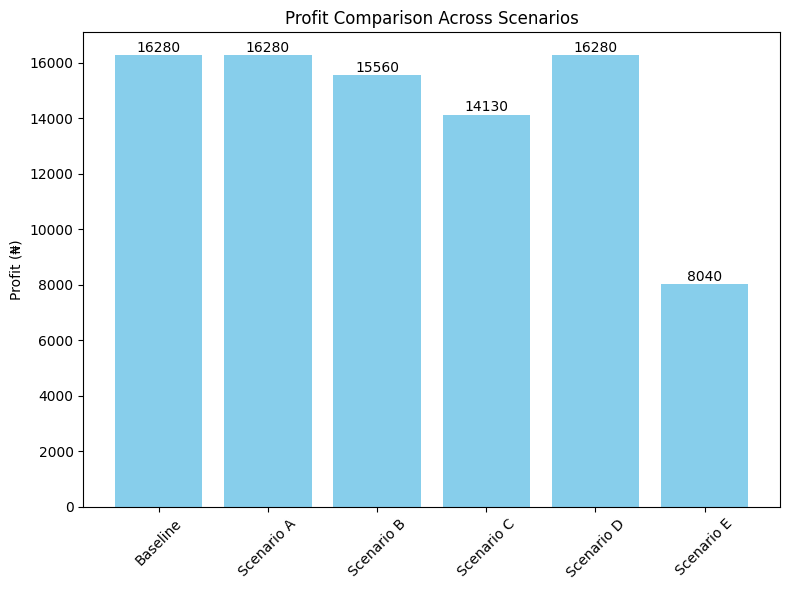

In [30]:
# Graphs for comparison
def plot_profit_comparison(profit_dict):
    scenarios = list(profit_dict.keys())
    profits = list(profit_dict.values())
    plt.figure(figsize=(8, 6))
    bars = plt.bar(scenarios, profits, color='skyblue')
    plt.title('Profit Comparison Across Scenarios')
    plt.ylabel('Profit (₦)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5,
                 f'{int(height)}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.grid(False)
    plt.show()

profits = {
    'Baseline': 16280,
    'Scenario A': 16280,
    'Scenario B': 15560,
    'Scenario C': 14130,
    'Scenario D': 16280,
    'Scenario E': 8040
}


plot_profit_comparison(profits)


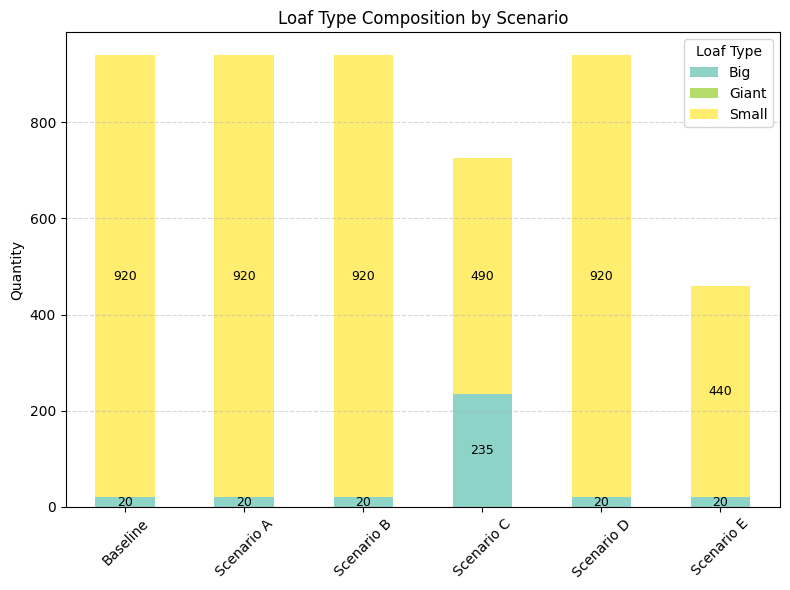

In [31]:
def stacked_loaf_plot_with_labels(data_dict):
    df = pd.DataFrame(data_dict, index=['Big', 'Giant', 'Small']).T

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = df.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')

    ax.set_title('Loaf Type Composition by Scenario')
    ax.set_ylabel('Quantity')
    ax.set_xticklabels(df.index, rotation=45)
    ax.legend(title='Loaf Type')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Add data labels to each bar segment
    for bar_group in bars.containers:
        for bar in bar_group:
            height = bar.get_height()
            if height > 0:
                bars.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f'{int(height)}',
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='black'
                )

    plt.show()

    data_dict = {
    'Baseline': [20, 0, 920],
    'Scenario A': [20, 0, 920],
    'Scenario B': [20, 0, 920],
    'Scenario C': [235, 0, 490],
    'Scenario D': [20, 0, 920],
    'Scenario E': [20, 0, 440],
}

stacked_loaf_plot_with_labels(data_dict)